# Lecture 3 - Generalized Linear Models: Ordinal Logistic Regression

## Today's Learning Goals

By the end of this lecture, you should be able to:

- Outline the modelling framework of the Ordinal Logistic regression.
- Explain the concept of proportional odds.
- Fit and interpret Ordinal Logistic regression.
- Use the Ordinal Logistic regression for prediction.
- Explain the concept of non-proportional odds.
- Assess the assumption of proportional odds via the Brant-Wald test.
- Contrast the Ordinal Logistic regression models under proportional and non-proportional odds assumptions.

## Loading Libraries

In [1]:
options(repr.matrix.max.rows = 6)
source("../scripts/support_functions.R")
library(VGAM)
library(cowplot)
library(tidyverse)
library(broom)
library(scales)
library(foreign)
library(MASS)
library(brant)

Loading required package: stats4



Loading required package: splines



── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     


── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::lag()       masks stats::lag()
✖ lubridate::stamp() masks cowplot::stamp()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors



Attaching package: ‘scales’




The following object is masked from ‘package:purrr’:

    discard




The following object is masked from ‘package:readr’:

    col_factor





Attaching package: ‘MASS’




The following object is masked from ‘package:dplyr’:

    select




## 1. The Need for an Ordinal Model

We will continue with Regression Analysis on **categorical responses**. Recall that a **discrete response** is considered as categorical if it is of factor-type with more than two categories under the following subclassification:

- **Nominal.** We have categories that do not follow any specific order—for example, the type of dwelling according to the Canadian census: *single-detached house*, *semi-detached house*, *row house*, *apartment*, and *mobile home*.
- **Ordinal.** The categories, in this case, follow a specific order—for example, a Likert scale of survey items: *strongly disagree*, *disagree*, *neutral*, *agree*, and *strongly agree*.

The previous Multinomial Logistic model, from {doc}`lecture2_glm_model_selection_multinomial`, **is unsuitable for ordinal responses**. For example, suppose one does not consider the order in the response levels when necessary. In that case, **we might risk losing valuable information when making inference or predictions**. This valuable information is in the ordinal scale, which could be set up via cumulative probabilities (recall **DSCI 551** concepts).

Therefore, the ideal approach is an alternative logistic regression that suits **ordinal** responses. Hence, the existence of the **Ordinal Logistic regression model**. Let us expand the regression mindmap as in {numref}`reg-mindmap-4` to include this new model. Note there is a key characteristic called **proportional odds**, which is reflected in the **data modelling framework** and to be discussed today.

````{div} full-width
```{figure} ../img/reg-mindmap-4.png
:height: 900px
:name: reg-mindmap-4
Expanded regression modelling mind map.
```
````

## 2. College Juniors Dataset

To illustrate the use of this generalized linear model (GLM), let us introduce an adequate dataset.

```{admonition} The College Juniors Dataset
The data frame `college_data` was obtained from the webpage of the [UCLA Statistical Consulting Group](https://stats.idre.ucla.edu/r/dae/ordinal-logistic-regression/).

This dataset contains the results of a survey applied to $n = 400$ college juniors regarding the factors that influence their decision to apply to graduate school.
 ```

In [2]:
college_data <- read_csv("../datasets/college_data.csv", show_col_types = FALSE)
college_data

decision,parent_ed,GPA
<chr>,<chr>,<dbl>
very likely,No,3.26
somewhat likely,Yes,3.21
unlikely,Yes,3.94
⋮,⋮,⋮
somewhat likely,No,2.25
somewhat likely,No,3.26
very likely,No,3.52


The dataset contains the following variables:

- `decision`: how likely the student will apply to graduate school, **a discrete and ordinal response with three increasing categories** (`unlikely`, `somewhat likely`, and `very likely`).
- `parent_ed`: whether at least one parent has a graduate degree, **a discrete and binary explanatory variable** (`Yes` and `No`).
- `GPA`: the student's current GPA, **a continuous explanatory variable**.

```{important}
In this example, variable `decision` will be our response of interest. However, before proceeding with our regression analysis. Let us set it up as an **ordered factor** via function `as.ordered()`.
```

In [3]:
college_data$decision <- as.ordered(college_data$decision)
college_data$decision <- fct_relevel(
  college_data$decision,
  c("unlikely", "somewhat likely", "very likely")
)
levels(college_data$decision)

[1] "unlikely"        "somewhat likely" "very likely"

```{admonition} Main Statistical Inquiries
Let us suppose we want to assess the following:

- Is `decision` statistically related to `parent_ed` and `GPA`?
- How can we interpret these statistical relationships (**if there are any!**)?
```

## 3. Exploratory Data Analysis

Let us plot the data first. Since `decision` is a **discrete and ordinal response**, we have to be careful about the class of plots we are using regarding exploratory data analysis (EDA).

To explore visually the relationship between `decision` and `GPA` , we will use the following side-by-side plots:

- **Boxplots.**
- **Violin plots.**

The code below creates side-by-side boxplots and violin plots, where `GPA` is on the $y$-axis, and all categories of `decision` are on the $x$-axis. The side-by-side violin plots show the mean of `GPA` by `decision` category in red points.

In [4]:
college_data_side_boxplots <- college_data |>
  ggplot(aes(decision, GPA)) +
  geom_boxplot(aes(fill = decision)) +
  labs(y = "GPA", x = "Decision to Apply to Graduate School") +
  ggtitle("Side-by-Side Boxplots") +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18),
    legend.position = "none"
  ) +
  scale_fill_brewer(palette="BuPu")

college_data_side_violin <- college_data |>
  ggplot(aes(decision, GPA)) +
  geom_violin(aes(fill = decision)) +
  labs(y = "GPA", x = "Decision to Apply to Graduate School") +
  ggtitle("Side-by-Side Violin Plots") +
  stat_summary(
    fun = mean, colour = "red", geom = "point",
    shape = 18, size = 5
  ) +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text = element_text(size = 17),
    axis.title = element_text(size = 18),
    legend.position = "none"
  ) +
  scale_fill_brewer(palette="BuPu")


Now, **how can we visually explore the relationship between `decision` and `parent_ed`?**

In the case of two categorical explanatory variables, **we can use stacked bar charts.** Each bar will show the percentages (depicted on the $y$-axis) of college students falling on each ordered category of `decision` with the categories found in `parent_ed` on the $x$-axis. This class of bars will allow us to compare both levels of `parent_ed` in terms of the categories of `decision`.

First of all, we need to do some data wrangling. The code below obtains the proportions for each level of `decision` conditioned on the categories of `parent_ed`. If we add up all proportions corresponding to `No` or `Yes`, we will obtain 1.

In [5]:
college_data_prop_summary <- as.data.frame(xtabs(
  ~ parent_ed +
    decision,
  college_data
) / rowSums(xtabs(
  ~ parent_ed + decision,
  college_data
)), responseName = "prop")

college_data_prop_summary

parent_ed,decision,prop
<fct>,<fct>,<dbl>
No,unlikely,0.59347181
Yes,unlikely,0.31746032
No,somewhat likely,0.32640950
Yes,somewhat likely,0.47619048
No,very likely,0.08011869
Yes,very likely,0.20634921


Then, we code the corresponding plot:

In [6]:
college_data_stacked_bars <- ggplot(college_data_prop_summary, aes(
  x = parent_ed,
  y = prop, fill = decision
)) +
  geom_bar(stat = "identity", width = 0.7, colour = "black") +
  geom_text(aes(label = ifelse(prop >= 0.05, paste0(sprintf("%.0f", prop * 100), "%"), "")),
    position = position_stack(vjust = 0.5), colour = "firebrick3", fontface = "bold", size = 6
  ) +
  scale_y_continuous(labels = percent_format()) +
  labs(y = "Percent", x = "Parent Education Status", fill = "") +
  ggtitle("Stacked Bar Charts") +
  theme(
    plot.title = element_text(size = 19, face = "bold"),
    axis.text.x = element_text(size = 17, angle = 0),
    axis.text.y = element_text(size = 17, angle = 0),
    axis.title = element_text(size = 18),
    legend.text = element_text(size = 18, margin = margin(r = 1, unit = "cm")),
    legend.title = element_text(size = 17, face = "bold")
  ) +
  guides(fill = guide_legend(title = "Decision")) +
  scale_fill_brewer(palette = "Blues")

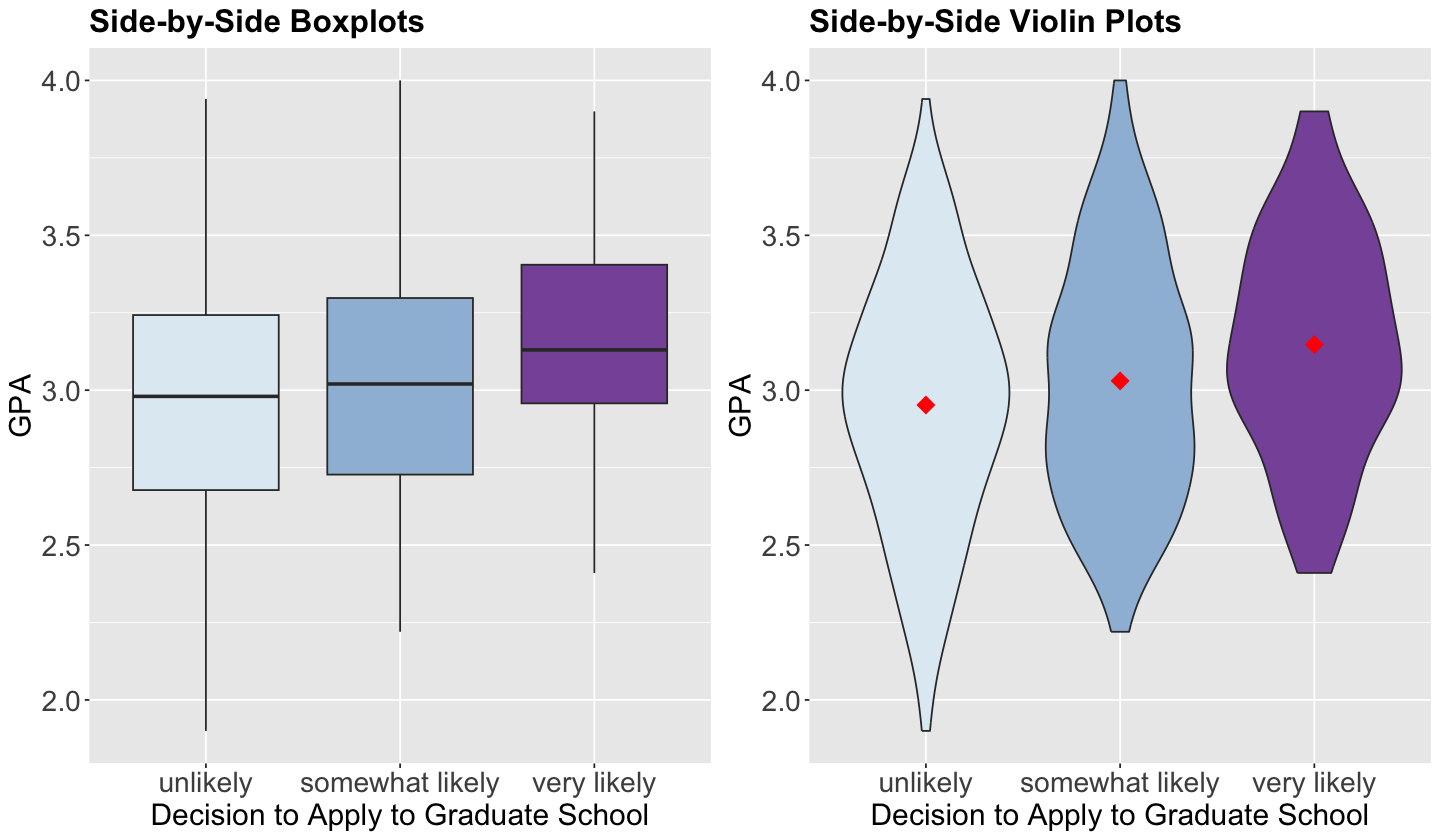

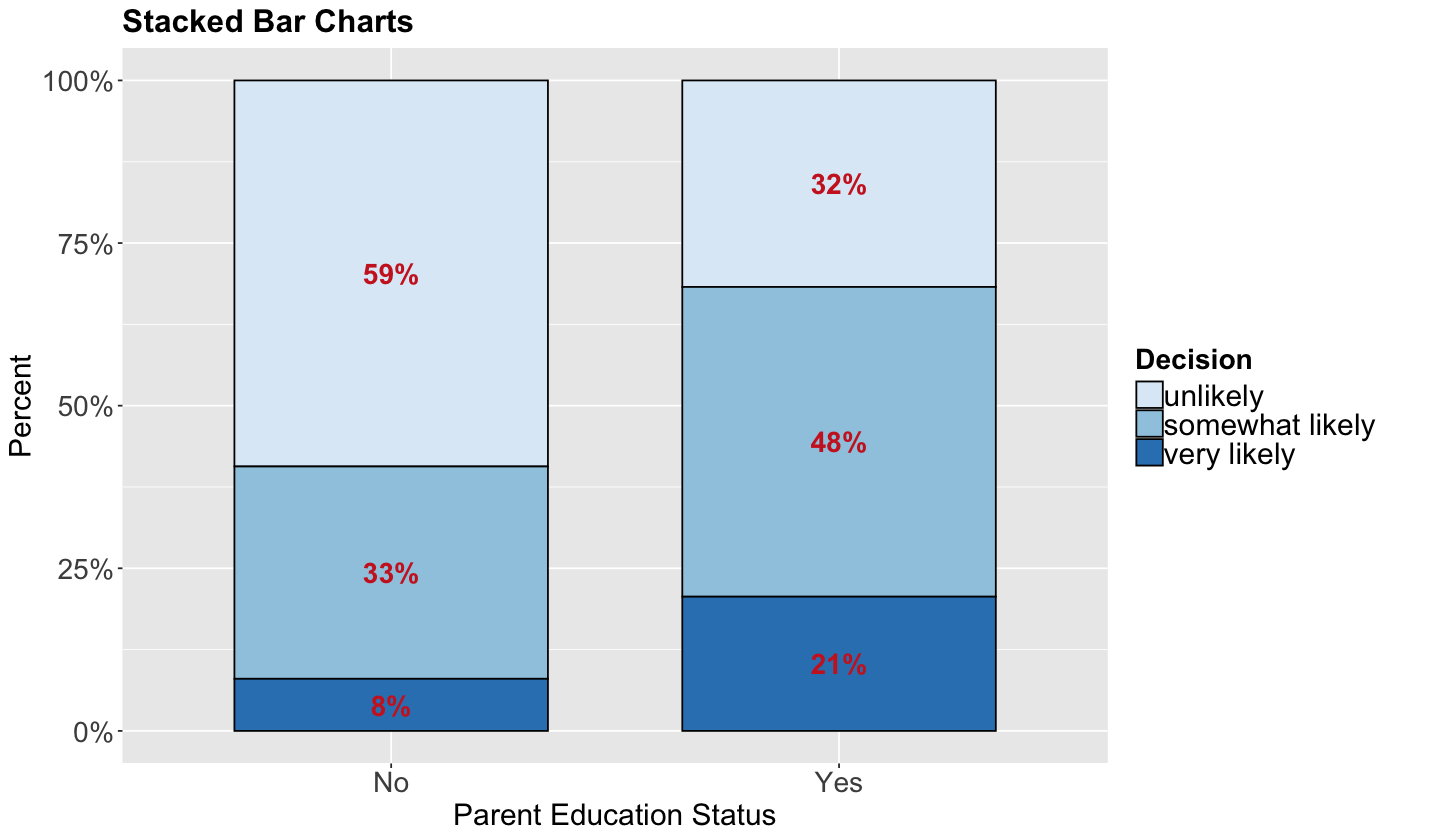

In [7]:
options(repr.plot.height = 7, repr.plot.width = 12)

plot_grid(college_data_side_boxplots, college_data_side_violin, nrow = 1)
college_data_stacked_bars

```{exercise}
:label: lecture3-q1

What can we see **descriptively** from the above plots?
```

```{solution} lecture3-q1
:label: lecture3-ans1

Those students with higher `GPA` tend to be `very likely` to apply to graduate school. Interestingly, those students with at least one parent with a graduate degree tend to be `very likely` to apply to graduate school.
```

## 4. Data Modelling Framework

Let us suppose that a given **discrete ordinal response** $Y_i$ (for $i = 1, \dots, n$) has categories $1, 2, \dots, m$ in a training set of size $n$.

```{important}
Categories $1, 2, \dots, m$ **implicate an ordinal scale here**, i.e., $1 < 2 < \dots < m$.

Also, note there is more than one class of Ordinal Logistic regression. We will review the **proportional odds** version, which is also a **cumulative logit model**.
```

We set up the Ordinal Logistical regression model for this specific dataset with $m = 3$. For the $i$th observation with the continuous $X_{i, \texttt{GPA}}$ and the dummy variable 

$$
X_{i, \texttt{parent_ed}} =
\begin{cases}
1 \; \; \; \; \mbox{at least one parent has a graduate degree},\\
0 \; \; \; \; 	\mbox{neither of the parents has a graduate degree;}
\end{cases}
$$

the model will indicate how each one of the regressors affects the **cumulative logarithm of the odds** in `decision` for the following $2$ situations:

```{math}
\begin{gather*}
\text{Level } \texttt{somewhat likely}  \text{ or any lesser degree versus level } \texttt{very likely} \\
\text{Level } \texttt{unlikely} \text{ versus level } \texttt{somewhat likely} \text{ or any higher degree}
\end{gather*}
```

Then, we have the following system of $2$ equations:

```{math}
\begin{align*}
\eta_i^{(\texttt{somewhat likely})} &= \log\left[\frac{P(Y_i \leq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{P(Y_i = \texttt{very likely} \mid X_{i, \texttt{GPA}}, X_{i, \texttt{parent_ed}})}\right] \\ &= \beta_0^{(\texttt{somewhat likely})} - \beta_1 X_{i, \texttt{GPA}} - \beta_2 X_{i, \texttt{parent_ed}}
\end{align*}
```

```{math}
\begin{align*}
\eta_i^{(\texttt{unlikely})} &= \log\left[\frac{P(Y_i = \texttt{unlikely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{P(Y_i \geq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}\right] \\ &= \beta_0^{(\texttt{unlikely})} - \beta_1 X_{i, \texttt{GPA}} - \beta_2 X_{i, \texttt{parent_ed}}.
\end{align*}
```

The system has $2$ intercepts but **only $2$ regression coefficients**. Check the signs of the **common** $\beta_1$ and $\beta_2$, which are minuses. This is a fundamental parameterization of the **proportional odds** model.

To make coefficient intepretation easier, we could re-expresss the equations of $\eta_i^{(\texttt{somewhat likely})}$  and $\eta_i^{(\texttt{unlikely})}$ as follows:

```{math}
\begin{equation*}
\frac{P(Y_i = \texttt{very likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{P(Y_i \leq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})} = \exp\big(-\beta_0^{(\texttt{somewhat likely})}\big) \exp\big(\beta_1 X_{i, \texttt{GPA}}\big) \exp\big(\beta_2 X_{i, \texttt{parent_ed}}\big)
\end{equation*}
```

```{math}
\begin{equation*}
\frac{P(Y_i \geq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{P(Y_i = \texttt{unlikely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})} = \exp\big(-\beta_0^{(\texttt{unlikely})}\big) \exp\big(\beta_1 X_{i, \texttt{GPA}}\big) \exp\big(\beta_2 X_{i, \texttt{parent_ed}}\big).
\end{equation*}
```

Both regression coefficients ($\beta_1$ and $\beta_2$) have a multiplicative effect on the odds on the left-hand side. Moreover, **given the proportional odds assumptions**, the regressor effects are the same for both cumulative odds.

**What is the math for the general case with $m$ response categories and $k$ regressors?**

Before going into the model's mathematical notation, we have to point out that Ordinal Logistic regression will indicate how each one of the $k$ regressors $X_{i,1}, \dots, X_{i,k}$ affects the **cumulative logarithm of the odds** in the ordinal response  for the following $m - 1$ situations:

```{math}
\begin{gather*}
\text{Level } m - 1 \text{ or any lesser degree versus level } m\\
\text{Level } m - 2 \text{ or any lesser degree versus level } m - 1 \text{ or any higher degree}\\
\vdots \\
\text{Level } 2 \text{ or any lesser degree versus level } 3 \text{ or any higher degree}\\
\text{Level } 1 \text{ versus level } 2 \text{ or any higher degree}\\
\end{gather*}
```

These $m - 1$ situations are translated into cumulative probabilities using the logarithms of the odds on the left-hand side ($m - 1$ link functions) subject to the linear combination of the $k$ regressors $X_{i,j}$ (for $j = 1, \dots, k$):

```{math}
\begin{gather*}
\eta_i^{(m - 1)} = \log\left[\frac{P(Y_i \leq m - 1 \mid X_{i,1}, \ldots, X_{i,k})}{P(Y_i = m \mid X_{i,1}, \ldots, X_{i,k})}\right] = \beta_0^{(m - 1)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_k X_{i, k} \\
\eta_i^{(m - 2)} = \log\left[\frac{P(Y_i \leq m - 2 \mid X_{i,1}, \ldots, X_{i,k})}{P(Y_i > m - 2 \mid X_{i,1}, \ldots, X_{i,k})}\right] = \beta_0^{(m - 2)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_k X_{i, k} \\
\vdots \\
\eta_i^{(2)} = \log\left[\frac{P(Y_i \leq 2 \mid X_{i,1}, \ldots, X_{i,k})}{P(Y_i > 2 \mid X_{i,1}, \ldots, X_{i,k})}\right] = \beta_0^{(2)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_k X_{i, k} \\
\eta_i^{(1)} = \log\left[\frac{P(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,k})}{P(Y_i > 1 \mid X_{i,1}, \ldots, X_{i,k})}\right] = \beta_0^{(1)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_k X_{i, k}.
\end{gather*}
```

Note that the system above has $m - 1$ intercepts but **only $k$ regression coefficients**. In general, the previous $m - 1$ equations can be generalized for levels $j = m - 1, \dots, 1$ as follows:

```{math}
\begin{gather*}
\eta_i^{(j)} = \log\left[\frac{P(Y_i \leq j \mid X_{i,1}, \ldots, X_{i,k})}{P(Y_i > j \mid X_{i,1}, \ldots, X_{i,k})}\right] = \beta_0^{(j)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_k X_{i, k} \\
\; \; \; \; \; \; \; \; \Rightarrow \; P(Y_i \leq j \mid X_{i,1}, \ldots, X_{i,k}) = \frac{\exp\left(\beta_0^{(j)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_k X_{i, k}\right)}{1 + \exp\left(\beta_0^{(j)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \ldots - \beta_k X_{i, k}\right)}.
\end{gather*}
```

The probability that $Y_i$ will fall in the category $j$ can be computed as follows:

$$
p_{i,j} = P(Y_i = j \mid X_{i,1}, \ldots, X_{i,k}) = P(Y_i \leq j \mid X_{i,1}, \ldots, X_{i,k}) - P(Y_i \leq j - 1 \mid X_{i,1}, \ldots, X_{i,k}),
$$

which leads to

$$
P(Y_i = 1) = p_{i,1} \;\;\;\; P(Y_i = 2) = p_{i,2} \;\; \dots \;\; P(Y_i = m) = p_{i,m}
$$

where

$$
\sum_{j = 1}^m p_{i,j} = p_{i,1} + p_{i,2} + \dots + p_{i,m} = 1.
$$

```{attention}
You will prove why we have **proportional odds** in this model in the challenging **Exercise 4** of `lab2`.
```

Let us check the next in-class question via [**iClicker**](https://student.iclicker.com/).

```{exercise}
:label: lecture3-q2

Suppose we have a case with an ordered response of five levels and four continuous regressors; how many link functions, intercepts, and coefficients will our Ordinal Logistic regression model have under a proportional odds assumption?

**A.** Four link functions, four intercepts, and sixteen regression coefficients. 

**B.** Five link functions, five intercepts, and five regression coefficients. 

**C.** Five link functions, five intercepts, and twenty regression coefficients. 

**D.** Four link functions, four intercepts, and four regression coefficients. 
```

````{solution} lecture3-q2
:label: lecture3-ans2

The categories $1, 2, 3, 4, 5$ in the $i$th response $Y_i$ implicate an ordinal scale here, i.e., $1 < 2 < 3 < 4 < 5$. 

Hence, our Ordinal Logistic regression model will indicate how each one of the $4$ regressors $X_{i,1}$, $X_{i,2}$, $X_{i,3}$, and $X_{i,4}$ affects the **cumulative logarithm of the odds** in the ordinal response  for the following $4$ situations:

```{math}
\begin{gather*}
\text{Level } 4 \text{ or any lesser degree versus level } 5 \\
\text{Level } 3 \text{ or any lesser degree versus level } 4 \text{ or any higher degree}\\
\text{Level } 2 \text{ or any lesser degree versus level } 3 \text{ or any higher degree}\\
\text{Level } 1 \text{ versus level } 2 \text{ or any higher degree}\\
\end{gather*}
```

Then, our system of modelling equations will be:

```{math}
\begin{gather*}
\eta_i^{(4)} = \log\left[\frac{P(Y_i \leq 4 \mid X_{i,1}, \ldots, X_{i,4})}{P(Y_i = 5 \mid X_{i,1}, \ldots, X_{i,4})}\right] = \beta_0^{(4)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \beta_3 X_{i, 3} - \beta_4 X_{i, 4} \\
\eta_i^{(3)} = \log\left[\frac{P(Y_i \leq 3 \mid X_{i,1}, \ldots, X_{i,4})}{P(Y_i > 3 \mid X_{i,1}, \ldots, X_{i,4})}\right] = \beta_0^{(3)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \beta_3 X_{i, 3} - \beta_4 X_{i, 4} \\
\eta_i^{(2)} = \log\left[\frac{P(Y_i \leq 2 \mid X_{i,1}, \ldots, X_{i,4})}{P(Y_i > 2 \mid X_{i,1}, \ldots, X_{i,4})}\right] = \beta_0^{(2)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \beta_3 X_{i, 3} - \beta_4 X_{i, 4} \\
\eta_i^{(1)} = \log\left[\frac{P(Y_i = 1 \mid X_{i,1}, \ldots, X_{i,4})}{P(Y_i > 1 \mid X_{i,1}, \ldots, X_{i,4})}\right] = \beta_0^{(1)} - \beta_1 X_{i, 1} - \beta_2 X_{i, 2} - \beta_3 X_{i, 3} - \beta_4 X_{i, 4}.
\end{gather*}
```

As we can see above; we would need four link functions, four intercepts $\left( \beta_0^{(4)}, \beta_0^{(3)}, \beta_0^{(2)}, \beta_1^{(1)} \right)$, and four coefficients $\left( \beta_1, \beta_2, \beta_3, \beta_4 \right)$.
````

### A Graphical Intuition of the Proportional Odds Assumption

The challenging **Exercise 4** in `lab2` is about showing mathematically what the proportional odds assumption stands for in the Ordinal Logistic regression model with $k$ regressors and a training set size of $n$, using a response of $m$ levels in general. That said, let us show the graphical intuition with an example of an ordinal response of $5$ levels and a single continuous regressor $X_{i , 1}$ (**which is unbounded!**).

The system of cumulative logit equations is the following:

```{math}
\begin{gather*}
\eta_i^{(4)} = \log\left[\frac{P(Y_i \leq 4 \mid X_{i,1})}{P(Y_i = 5 \mid X_{i,1})}\right] = \beta_0^{(4)} - \beta_1 X_{i, 1} \\
\eta_i^{(3)} = \log\left[\frac{P(Y_i \leq 3 \mid X_{i,1})}{P(Y_i > 3 \mid X_{i,1})}\right] = \beta_0^{(3)} - \beta_1 X_{i, 1} \\
\eta_i^{(2)} = \log\left[\frac{P(Y_i \leq 2 \mid X_{i,1})}{P(Y_i > 2 \mid X_{i,1})}\right] = \beta_0^{(2)} - \beta_1 X_{i, 1} \\
\eta_i^{(1)} = \log\left[\frac{P(Y_i = 1 \mid X_{i,1})}{P(Y_i > 1 \mid X_{i,1})}\right] = \beta_0^{(1)} - \beta_1 X_{i, 1}.
\end{gather*}
```

This above system could be mathematically expressed as follows:

```{math}
\begin{gather*}
P(Y_i \leq 4 \mid X_{i,1}) = \frac{\exp\left(\beta_0^{(4)} - \beta_1 X_{i, 1} \right)}{1 + \exp\left(\beta_0^{(4)} - \beta_1 X_{i, 1}\right)} \\
P(Y_i \leq 3 \mid X_{i,1}) = \frac{\exp\left(\beta_0^{(3)} - \beta_1 X_{i, 1} \right)}{1 + \exp\left(\beta_0^{(3)} - \beta_1 X_{i, 1}\right)} \\
P(Y_i \leq 2 \mid X_{i,1}) = \frac{\exp\left(\beta_0^{(2)} - \beta_1 X_{i, 1} \right)}{1 + \exp\left(\beta_0^{(2)} - \beta_1 X_{i, 1}\right)} \\
P(Y_i \leq 1 \mid X_{i,1}) = \frac{\exp\left(\beta_0^{(1)} - \beta_1 X_{i, 1} \right)}{1 + \exp\left(\beta_0^{(1)} - \beta_1 X_{i, 1}\right)}. \\
\end{gather*}
```

Note we have four intercepts $(\beta_0^{(1)}, \beta_0^{(2)}, \beta_0^{(3)}, \beta_0^{(4)})$  and a single coefficient $\beta_1$. Moreover, let us assume we estimate these five parameters to be the following:

```{math}
\begin{gather*}
\hat{\beta}_0^{(1)} = 4\\
\hat{\beta}_0^{(2)} = 5.5 \\ 
\hat{\beta}_0^{(3)} = 6.3 \\ 
\hat{\beta}_0^{(4)} = 10 \\
\hat{\beta}_1 = 12.
\end{gather*}
```

Let us check our estimated sigmoid functions! As we can see in {numref}`sigmoid-functions`, the proportional odds assumption also implicates proportional sigmoid functions.

````{div} full-width
```{figure} ../img/sigmoid-functions.png
:height: 550px
:name: sigmoid-functions
Sigmoid functions under a proportional odds assumption (Copyright [**GeoGebra®**](https://www.geogebra.org/), 2024).
```
````

## 5. Estimation

**All parameters** in the Ordinal Logistic regression model are also unknown. Therefore, model estimates are obtained through **maximum likelihood**, where we also assume a **Multinomial joint probability mass function** of the $n$ responses $Y_i$. Moreover, this Multinomial assumption plays around with cumulative probabilities in the joint likelihood function **as discussed in [Agresti (2013)](https://ebookcentral.proquest.com/lib/ubc/detail.action?docID=1168529) in Chapter 8 (Section 8.2.2)**.

To fit the model with the package `MASS`, we use the function `polr()`, which obtains the corresponding estimates. The argument `Hess = TRUE` is required to compute the [Hessian matrix](https://mathworld.wolfram.com/Hessian.html) of the **log-likelihood function**, which is used to obtain the standard errors of the estimates.

In [8]:
ordinal_model <- polr(decision ~ parent_ed + GPA,
  data = college_data, Hess = TRUE
)

```{important}
Maximum likelihood estimation in this regression model is quite complex compared to the challenging **Exercise 5** in `lab1` for Binary Logistic regression. Thus, **the proof will be out of the scope of this course.**
```

```{admonition} Note
:class: note
If you would like to check a further rationale on the use of the Hessian matrix to obtain the standard errors of regression estimates, you can find good insights into this matter via the classical linear regression model (i.e., Ordinary Least-squares but in its maximum likelihood estimation flavour) [**in this resource**](https://tidystat.com/meaning-of-hessian-matrix-from-optim-in-r/).
```

## 6. Inference

**We can determine whether a regressor is statistically associated with the logarithm of the cumulative odds** through hypothesis testing for the parameters $\beta_j$. We also use the **Wald statistic** $z_j$:

$$
z_j = \frac{\hat{\beta}_j}{\mbox{se}(\hat{\beta}_j)}
$$

to test the hypotheses

```{math}
\begin{gather*}
H_0: \beta_j = 0\\
H_a: \beta_j \neq 0.
\end{gather*}
```

The **null hypothesis** $H_0$ indicates that the $j$th regressor associated to $\beta_j$ does not affect the response variable in the model, and the **alternative hypothesis** $H_a$ otherwise. Moreover, provided the sample size $n$ is large enough, $z_j$ has an **approximately Standard Normal distribution** under $H_0$.

`R` provides the corresponding **$p$-values** for each $\beta_j$. The smaller the $p$-value, the stronger the evidence against the null hypothesis $H_0$. As in the previous regression models, we would set a predetermined significance level $\alpha$ (usually taken to be 0.05) to infer if the $p$-value is small enough. If the $p$-value is smaller than the predetermined level $\alpha$, then you could claim that there is evidence to reject the null hypothesis. Hence, $p$-values that are small enough indicate that the data provides evidence in favour of **association** (**or causation in the case of an experimental study!**) between the response variable and the $j$th regressor.

Furthermore, given a specified level of confidence where $\alpha$ is the significance level, we can construct approximate $(1 - \alpha) \times 100\%$ **confidence intervals** for the corresponding true value of $\beta_j$:

$$
\hat{\beta}_j \pm z_{\alpha/2}\mbox{se}(\hat{\beta}_j),
$$

where $z_{\alpha/2}$ is the upper $\alpha/2$ quantile of the **Standard Normal distribution**.

Function `polr()` does not provide $p$-values, but we can compute them as follows:

In [9]:
summary_ordinal_model <- cbind(tidy(ordinal_model),
  p.value = pnorm(abs(tidy(ordinal_model)$statistic),
    lower.tail = FALSE
  ) * 2
) |>
  mutate_if(is.numeric, round, 2)
summary_ordinal_model

term,estimate,std.error,statistic,coef.type,p.value
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
parent_edYes,1.05,0.27,3.94,coefficient,0.00
GPA,0.60,0.25,2.38,coefficient,0.02
unlikely|somewhat likely,2.18,0.77,2.84,scale,0.00
somewhat likely|very likely,4.27,0.79,5.39,scale,0.00


Terms `unlikely|somewhat likely` and `somewhat likely|very likely` refer to the estimated intercepts $\hat{\beta}_0^{(\texttt{unlikely})}$ and $\hat{\beta}_0^{(\texttt{somewhat likely})}$, respectively (**note the hat notation**).

Finally, we see that those coefficients associated with `GPA` and `parent_ed` are statistically significant with $\alpha = 0.05$.

Function `confint()` can provide the 95% confidence intervals for the estimates contained in `tidy()`.

In [10]:
round(confint(ordinal_model), 2)

Waiting for profiling to be done...



,2.5 %,97.5 %
parent_edYes,0.53,1.57
GPA,0.11,1.11


## 7. Coefficient Interpretation

The interpretation of the Ordinal Logistic regression coefficients will change since we are modelling cumulative probabilities. Let us interpret the association of `decision` with `GPA` and `parent_ed`.

In [11]:
tibble(summary_ordinal_model[1:2, 1:2], exp.estimate = round(exp(summary_ordinal_model[1:2, 2]), 2))

term,estimate,exp.estimate
<chr>,<dbl>,<dbl>
parent_edYes,1.05,2.86
GPA,0.60,1.82


By using the column `exp.estimate`, **along with the model equations on the original scale of the cumulative odds**, we interpret the two regression coefficients above **by each odds** as follows:

For the odds 

$$\frac{P(Y_i = \texttt{very likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{P(Y_i \leq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})} = \exp\big(-\beta_0^{(\texttt{somewhat likely})}\big) \exp\big(\beta_1 X_{i, \texttt{GPA}}\big) \exp\big(\beta_2 X_{i, \texttt{parent_ed}}\big).$$

> - $\beta_1$: "for each one-unit increase in the `GPA`, the odds that the student is `very likely`  versus `somewhat likely` or `unlikely` to apply to graduate school increase by $\exp \left( \hat{\beta}_1 \right) = 1.82$ times (while holding `parent_ed` constant)."

> - $\beta_2$: "for those respondents whose parents attended to graduate school, the odds that the student is `very likely` versus `somewhat likely` or `unlikely` to apply to graduate school increase by $\exp \left( \hat{\beta}_2 \right) = 2.86$ times (when compared to those respondents whose parents did not attend to graduate school and holding `GPA` constant)."

For the odds 

$$\frac{P(Y_i \geq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{P(Y_i = \texttt{unlikely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})} = \exp\big(-\beta_0^{(\texttt{unlikely})}\big) \exp\big(\beta_1 X_{i, \texttt{GPA}}\big) \exp\big(\beta_2 X_{i, \texttt{parent_ed}}\big).$$

> - $\beta_1$: "for each one-unit increase in the `GPA`, the odds that the student is `very likely` or `somewhat likely` versus `unlikely` to apply to graduate school increase by $\exp \left( \hat{\beta}_1 \right) = 1.82$ times (while holding `parent_ed` constant)."

> - $\beta_2$: "for those respondents whose parents attended to graduate school, the odds that the student is `very likely`  or `somewhat likely` versus `unlikely` to apply to graduate school increase by $\exp \left( \hat{\beta}_2 \right) = 2.86$ times (when compared to those respondents whose parents did not attend to graduate school and holding `GPA` constant)."

## 8. Predictions

**Aside from our main statistical inquiries**, using the function `predict()` with the object `ordinal_model`, we can obtain the estimated probabilities to apply to graduate school (associated to `unlikely`, `somewhat likely`, and `very likely`) for a student with a `GPA` of 3.5 whose parents attended to graduate school.

In [12]:
round(predict(ordinal_model, tibble(GPA = 3.5, parent_ed = "Yes"), type = "probs"), 2)

unlikely somewhat likely     very likely 
           0.27            0.48            0.25

We can see that it is `somewhat likely` to apply to graduate school with a probability of 0.48. **Thus, we could classify the student in this ordinal category.**

Unfortunately, `predict()` with `polr()` does not provide a quick way to compute this model's corresponding predicted cumulative odds for a new observation. Nonetheless, we could use function `vglm()`(from package `VGAM`) again while keeping in mind that **this function labels the response categories as numbers**. Let us check this for `decision` with `levels()`.

In [13]:
levels(college_data$decision)

[1] "unlikely"        "somewhat likely" "very likely"

Hence, `unlikely` is `1`, `somewhat likely` is `2`, and `very likely` is `3`. Now, let us use `vglm()` with `propodds` to fit the same model (named `ordinal_model_vglm`) as follows:

In [14]:
ordinal_model_vglm <- vglm(decision ~ parent_ed + GPA, propodds,
  data = college_data)

summary(ordinal_model_vglm)

Call:
vglm(formula = decision ~ parent_ed + GPA, family = propodds, 
    data = college_data)

Coefficients: 
              Estimate Std. Error z value Pr(>|z|)    
(Intercept):1  -2.1763     0.7726  -2.817  0.00485 ** 
(Intercept):2  -4.2716     0.7976  -5.356 8.52e-08 ***
parent_edYes    1.0457     0.2682   3.899 9.67e-05 ***
GPA             0.6043     0.2561   2.360  0.01829 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Names of linear predictors: logitlink(P[Y>=2]), logitlink(P[Y>=3])

Residual deviance: 717.0638 on 796 degrees of freedom

Log-likelihood: -358.5319 on 796 degrees of freedom

Number of Fisher scoring iterations: 4 

No Hauck-Donner effect found in any of the estimates


Exponentiated coefficients:
parent_edYes          GPA 
    2.845388     1.829895 

We will double-check whether `ordinal_model_vglm` provides the same classification probabilities via `predict()`. Note that the function parameterization changes to `type = "response"`.

In [15]:
round(predict(ordinal_model_vglm, tibble(GPA = 3.5, parent_ed = "Yes"), type = "response"), 2)

,unlikely,somewhat likely,very likely
1,0.27,0.48,0.25


Yes, we get identical results using `vglm()`. Now, let us use `predict()` with `ordinal_model_vglm` to obtain the predicted cumulative odds for a student with a `GPA` of 3.5 whose parents attended to graduate school (via argument `type = "link"` in `predict()`).

In [16]:
round(predict(ordinal_model_vglm, tibble(GPA = 3.5, parent_ed = "Yes"), type = "link"), 2)

,logitlink(P[Y>=2]),logitlink(P[Y>=3])
1,0.98,-1.11


Then, let us take these predictions to the odds' original scale via `exp()`.

In [17]:
round(exp(predict(ordinal_model_vglm, tibble(GPA = 3.5, parent_ed = "Yes"), type = "link")), 2)

,logitlink(P[Y>=2]),logitlink(P[Y>=3])
1,2.68,0.33


Again, we see the numeric labels **(a drawback of using `vglm()`)**. We interpret these predictions as follows:

- $\frac{P(Y_i = \texttt{very likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{P(Y_i \leq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}$, i.e., `P[Y>=3]` (label `3`, `very likely`): "**a student, with a `GPA` of 3.5 whose parents attended to graduate school, is 3.03 ($1 / 0.33$) times `somewhat likely` or `unlikely` versus `very likely` to apply to graduate school**." This prediction goes in line with the predicted probabilities above, given that `somewhat likely` has a probability of 0.48 and `unlikely` a probability of 0.27.

- $\frac{P(Y_i \geq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{P(Y_i = \texttt{unlikely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}$, i.e., `P[Y>=2]` (label `2`, ` somewhat likely`): "**a student, with a `GPA` of 3.5 whose parents attended to graduate school, is 2.68 times `very likely` or `somewhat likely` versus `unlikely` to apply to graduate school**." This prediction goes in line with the predicted probabilities above, given that `somewhat likely` has a probability of 0.48 and ` very likely` a probability of 0.25.

## 9. Model Selection

**To perform model selection**, we can use the same techniques from the Binary Logistic regression model (check {ref}`bin-log-model-selection`). That said, some `R` coding functions might not be entirely available for the `polr()` models. Still, these statistical techniques and metrics can be manually coded.

## 10. Non-proportional Odds

Now, we might wonder

> What happens if we do not fulfil the proportional odds assumption in our Ordinal Logistic regression model?

### 10.1. The Brant-Wald Test

It is essential to remember that the Ordinal Logistic model under the proportional odds assumption is **the first step** when performing Regression Analysis on an ordinal response. 

Once this model has been fitted, **it is possible to assess whether it fulfils this strong assumption statistically**.

We can do it via the Brant-Wald test:

- This tool statistically assesses whether our model globally fulfils this assumption. It has the following hypotheses:

```{math}
\begin{gather*}
H_0: \text{Our Ordinal Logistic regression model globally fulfils the proportional odds assumption.} \\
H_a: \text{Otherwise}.
\end{gather*}
```

- Moreover, it also performs further hypothesis testing on each regressor. With $k$ regressors for $j = 1, \dots, k$; we have the following hypotheses:

```{math}
\begin{gather*}
H_0: \text{The } j \text{th regressor in our Ordinal Logistic regression model fulfils the proportional odds assumption.} \\
H_a: \text{Otherwise}.
\end{gather*}
```

Function `brant()` from package `brant` implements this tool, which can be used in our `polr()` object `ordinal_model`:

In [18]:
brant(ordinal_model)

-------------------------------------------- 
Test for	X2	df	probability 
-------------------------------------------- 
Omnibus		0.73	2	0.69
parent_edYes	0.09	1	0.76
GPA		0.7	1	0.4
-------------------------------------------- 

H0: Parallel Regression Assumption holds


The row `Omnibus` represents the global model, while the other two rows correspond to our two regressors: `parent_ed` and `GPA`. Note that with $\alpha = 0.05$, we are completely fulfilling the proportional odds assumption (the column `probability` delivers the corresponding $p$-values).

```{important} 
The Brant Wald test essentially compares this basic Ordinal Logistic regression model of $k-1$ cumulative logit functions versus a combination of $k − 1$ correlated Binary Logistic regressions.
```

### 10.2. A Non-proportional Odds Model

Suppose that our example case **does not fulfil** the proportional odds assumption according to the Brant Wald test. It is possible to have a model under a **non-proportional odds assumption** as follows:

```{math}
\begin{align*}
\eta_i^{(\texttt{somewhat likely})} &= \log\left[\frac{P(Y_i \leq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{P(Y_i = \texttt{very likely} \mid X_{i, \texttt{GPA}}, X_{i, \texttt{parent_ed}})}\right] \\ &= \beta_0^{(\texttt{somewhat likely})} - \beta_1^{(\texttt{somewhat likely})} X_{i, \texttt{GPA}} - \beta_2^{(\texttt{somewhat likely})} X_{i, \texttt{parent_ed}}
\end{align*}
```

```{math}
\begin{align*}
\eta_i^{(\texttt{unlikely})} &= \log\left[\frac{P(Y_i = \texttt{unlikely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}{P(Y_i \geq \texttt{somewhat likely} \mid X_{i, \texttt{GPA}},X_{i, \texttt{parent_ed}})}\right] \\ &= \beta_0^{(\texttt{unlikely})} - \beta_1^{(\texttt{unlikely})} X_{i, \texttt{GPA}} - \beta_2^{(\texttt{unlikely})} X_{i, \texttt{parent_ed}}.
\end{align*}
```

This is called a **Generalized Ordinal Logistic regression model**. This class of models can be fit via [**the function `cumulative()`**](https://search.r-project.org/CRAN/refmans/VGAM/html/cumulative.html) from package `VGAM`. Note that estimation, inference, coefficient interpretation, and predictions are conducted in a similar way **compared to the proportional odds model**.

```{exercise}
:label: lecture3-q3

Why would we have to be cautious when fitting a non-proportional odds model in the context of a response with a considerable number of ordinal levels and regressors?
```

````{solution} lecture3-q3
:label: lecture3-ans3

The Ordinal Logistic regression framework makes complex modelling since we deal with cumulative probabilities by each logit function in the system. On top of that, adding a considerable number of regression parameters to estimate in our optimization procedure via maximum likelihood might make convergence slow when fitting the model.
````

## 11. Wrapping Up on Categorical Regression Models

- Multinomial and Ordinal Logistic regression models address cases where our response is discrete and categorical. These models are another class GLMs with their corresponding link functions.
- Multinomial Logistic regression approaches nominal responses. It heavily relies on a baseline response level and the odds' natural logarithm.
- Ordinal Logistic regression approaches ordinal responses. It relies on cumulative odds on an ordinal scale.
- We have to be careful with coefficient interpretations in these models, especially with the cumulative odds. This will imply an effective communication of these estimated models for inferential matters. 